In [1]:
#  Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time

In [4]:
#  Importing API key
from api_keys import bea_api_key

base_url = "https://apps.bea.gov/api/data/"

In [5]:
# BEA Client Class
class BEAClient:
    """
    A simple client for the Bureau of Economic Analysis API
    Makes it easy to fetch and work with economic data
    """
    
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = base_url
    
    def make_request(self, params):
        """Make a request to the BEA API"""
        params['UserID'] = self.api_key
        params['ResultFormat'] = 'JSON'
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"API request failed: {e}")
            return None
    
    def get_gdp_data(self, years=['2020', '2021', '2022', '2023', '2024']):
        """Get quarterly GDP data"""
        params = {
            'method': 'GetData',
            'datasetname': 'NIPA',
            'TableName': 'T10101',
            'Frequency': 'Q',
            'Year': ','.join(years)
        }
        print(f"Fetching GDP data for years: {', '.join(years)}")
        return self.make_request(params)
    
    def get_gdp_components(self, years=['2022', '2023', '2024']):
        """Get GDP components (consumption, investment, etc.)"""
        params = {
            'method': 'GetData',
            'datasetname': 'NIPA',
            'TableName': 'T10105',  # GDP components table
            'Frequency': 'Q',
            'Year': ','.join(years)
        }
        print(f"Fetching GDP components for years: {', '.join(years)}")
        return self.make_request(params)
    
    def get_state_personal_income(self, years=['2022', '2023']):
        """Get personal income by state"""
        params = {
            'method': 'GetData',
            'datasetname': 'Regional',
            'TableName': 'SAINC1',
            'LineCode': '1',
            'Year': ','.join(years),
            'GeoFips': 'STATE'
        }
        print(f"Fetching state personal income for years: {', '.join(years)}")
        return self.make_request(params)

# Initialize the client
client = BEAClient(bea_api_key)
print("✓ BEA Client initialized")

✓ BEA Client initialized


In [6]:
# Data Processing

def process_gdp_data(raw_data):
    """Convert GDP API response to a clean pandas DataFrame"""
    if not raw_data or 'BEAAPI' not in raw_data:
        print("No data received or invalid response")
        return None
    
    try:
        results = raw_data['BEAAPI']['Results']['Data']
        
        processed_data = []
        for item in results:
            # Handle missing or invalid data values
            try:
                value = float(item['DataValue'].replace(',', ''))
            except (ValueError, AttributeError):
                continue
                
            processed_data.append({
                'date': item['TimePeriod'],
                'gdp_billions': value,
                'line_description': item['LineDescription'],
                'table_name': item.get('TableName', 'Unknown')
            })
        
        df = pd.DataFrame(processed_data)
        
        if df.empty:
            print("No valid data found")
            return None
        
        # Create proper datetime index for time series analysis
        df['year'] = df['date'].str[:4].astype(int)
        df['quarter'] = df['date'].str[5:]
        df['datetime'] = pd.to_datetime(df['date'])
        df = df.sort_values('datetime')
        
        print(f"✓ Processed {len(df)} data points")
        return df
        
    except Exception as e:
        print(f"Error processing data: {e}")
        return None

def calculate_growth_rates(df, value_col='gdp_billions'):
    """Calculate various growth rates for economic analysis"""
    df = df.copy().sort_values('datetime')
    
    # Quarter-over-quarter growth (annualized)
    df['qoq_growth'] = df[value_col].pct_change() * 100 * 4
    
    # Year-over-year growth
    df['yoy_growth'] = df[value_col].pct_change(4) * 100
    
    # Rolling averages for smoothing
    df['gdp_4q_avg'] = df[value_col].rolling(4).mean()
    
    return df

In [7]:
# Fetch and Process GDP Data
print("=== Fetching GDP Data ===")
gdp_response = client.get_gdp_data()

if gdp_response:
    gdp_df = process_gdp_data(gdp_response)
    
    if gdp_df is not None:
        gdp_df = calculate_growth_rates(gdp_df)
        print(f"✓ GDP data ready: {len(gdp_df)} quarters of data")
        
        # Quick preview
        display(gdp_df[['date', 'gdp_billions', 'yoy_growth']].tail())
    else:
        print("Failed to process GDP data")
else:
    print("Failed to fetch GDP data")

=== Fetching GDP Data ===
Fetching GDP data for years: 2020, 2021, 2022, 2023, 2024
✓ Processed 500 data points
✓ GDP data ready: 500 quarters of data


,date,gdp_billions,yoy_growth
179,2024Q4,-3.0,500.000000
299,2024Q4,-4.6,-47.126437
319,2024Q4,8.5,54.545455
339,2024Q4,-1.9,-147.500000
499,2024Q4,4.8,-260.000000


In [8]:
# Basic GDP Analysis
if 'gdp_df' in locals() and gdp_df is not None:
    print("=== GDP Quick Analysis ===")
    
    latest = gdp_df.iloc[-1]
    print(f"Latest Quarter: {latest['date']}")
    print(f"GDP Level: ${latest['gdp_billions']:,.1f} billion")
    print(f"YoY Growth: {latest['yoy_growth']:.1f}%")
    print(f"QoQ Growth (annualized): {latest['qoq_growth']:.1f}%")
    
    # Summary statistics
    print("\n=== Growth Rate Statistics ===")
    growth_stats = gdp_df['yoy_growth'].describe()
    print(growth_stats)

=== GDP Quick Analysis ===
Latest Quarter: 2024Q4
GDP Level: $4.8 billion
YoY Growth: -260.0%
QoQ Growth (annualized): -1410.5%

=== Growth Rate Statistics ===
count    4.960000e+02
mean              inf
std               NaN
min     -1.120000e+04
25%     -1.486111e+02
50%     -5.803202e+01
75%      3.569444e+01
max               inf
Name: yoy_growth, dtype: float64


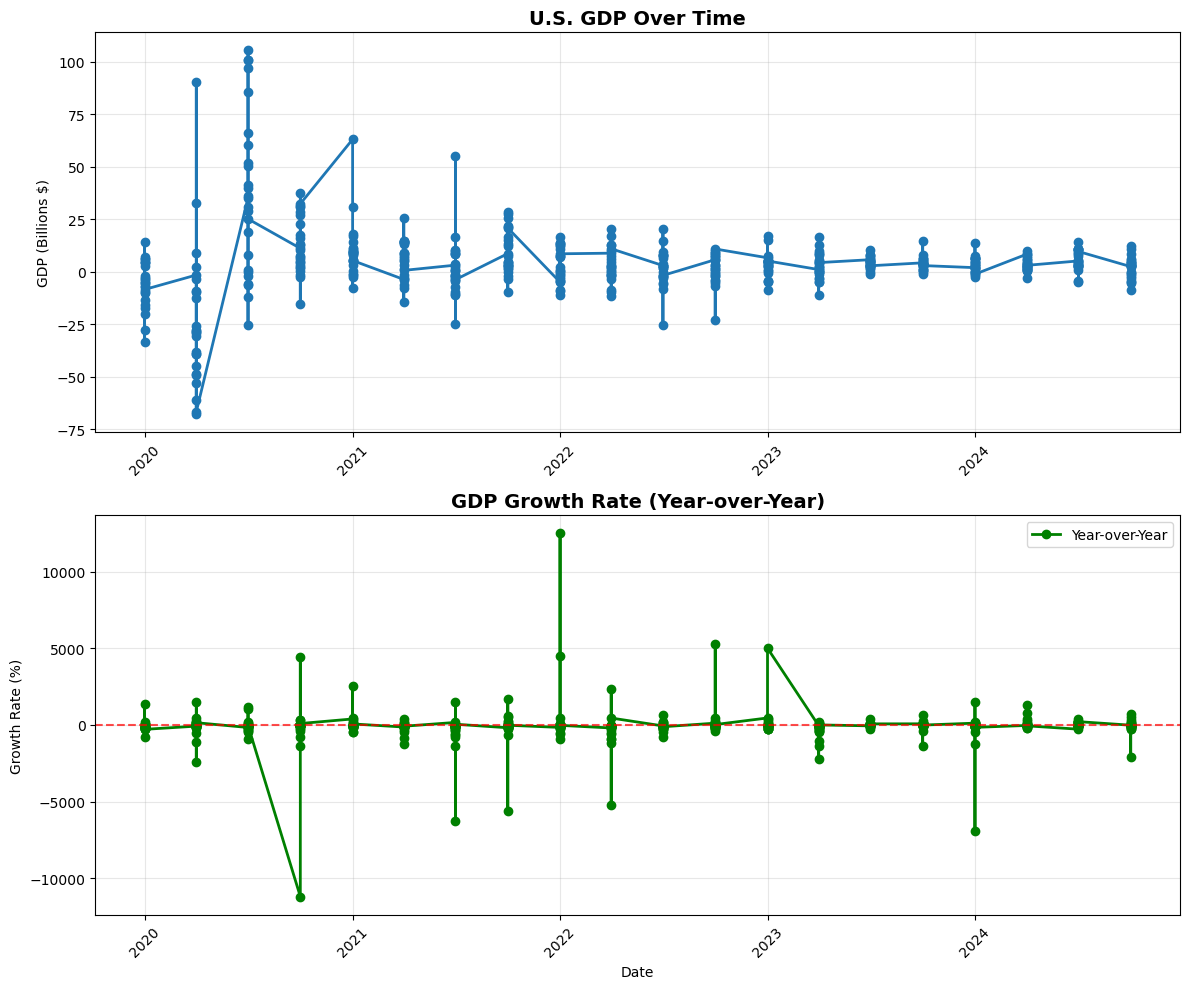

In [9]:
# GDP Visualization
if 'gdp_df' in locals() and gdp_df is not None:
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # GDP Level over time
    axes[0].plot(gdp_df['datetime'], gdp_df['gdp_billions'], linewidth=2, marker='o')
    axes[0].set_title('U.S. GDP Over Time', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('GDP (Billions $)')
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Growth rates
    axes[1].plot(gdp_df['datetime'], gdp_df['yoy_growth'], 
                linewidth=2, marker='o', color='green', label='Year-over-Year')
    axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[1].set_title('GDP Growth Rate (Year-over-Year)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Growth Rate (%)')
    axes[1].set_xlabel('Date')
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [10]:
# Explore GDP Components
print("=== Fetching GDP Components ===")
components_response = client.get_gdp_components()

if components_response:
    components_df = process_gdp_data(components_response)
    if components_df is not None:
        print("✓ GDP components data fetched")
        
        # Show what components we have
        print("\nAvailable GDP components:")
        component_types = components_df['line_description'].unique()
        for i, comp in enumerate(component_types[:10]):  # Show first 10
            print(f"{i+1}. {comp}")
        
        # Focus on major components
        major_components = components_df[
            components_df['line_description'].str.contains(
                'Personal consumption|Gross private domestic investment|Government|Net exports',
                case=False, na=False
            )
        ]
        
        if not major_components.empty:
            display(major_components[['date', 'line_description', 'gdp_billions']].tail())

=== Fetching GDP Components ===
Fetching GDP components for years: 2022, 2023, 2024
✓ Processed 312 data points
✓ GDP components data fetched

Available GDP components:
1. Gross domestic product
2. Goods
3. Residential
4. Intellectual property products
5. Equipment
6. State and local
7. Durable goods
8. Nondefense
9. Federal
10. Services


,date,line_description,gdp_billions
178,2024Q3,Net exports of goods and services,-943684.0
23,2024Q4,Personal consumption expenditures,20255455.0
83,2024Q4,Gross private domestic investment,5288763.0
179,2024Q4,Net exports of goods and services,-920084.0
263,2024Q4,Government consumption expenditures and gross ...,5099730.0


In [19]:
# State-Level Analysis
print("=== Fetching State Personal Income Data ===")
state_response = client.get_state_personal_income()

if state_response:
    state_df = process_gdp_data(state_response)
    if state_df is not None:
        print("✓ State personal income data fetched")
        
        # Get latest year data
        latest_year = state_df['year'].max()
        latest_state_data = state_df[state_df['year'] == latest_year]
        
        # Top 10 states by personal income
        top_states = latest_state_data.nlargest(10, 'gdp_billions')
        
#         list(state_df.index)
        
        print(f"\nTop 10 States by Personal Income ({latest_year}):")
        display(top_states[['line_description', 'gdp_billions']].reset_index(drop=True))

=== Fetching State Personal Income Data ===
Fetching state personal income for years: 2022, 2023
❌ Error processing data: 'LineDescription'


In [ ]:
# Save Data for Further Analysis
# if 'gdp_df' in locals() and gdp_df is not None:
#     # Save to CSV
#     gdp_df.to_csv('bea_gdp_data.csv', index=False)
#     print("✓ GDP data saved to 'bea_gdp_data.csv'")
    
#     # Save to Excel with multiple sheets if we have component data
#     with pd.ExcelWriter('bea_economic_data.xlsx') as writer:
#         gdp_df.to_excel(writer, sheet_name='GDP_Data', index=False)
        
#         if 'components_df' in locals() and components_df is not None:
#             components_df.to_excel(writer, sheet_name='GDP_Components', index=False)
        
#         if 'state_df' in locals() and state_df is not None:
#             state_df.to_excel(writer, sheet_name='State_Income', index=False)
    
#     print("✓ All data saved to 'bea_economic_data.xlsx'")

In [14]:
# Helpful Functions for Continued Exploration
def explore_available_datasets():
    """See what datasets are available in BEA"""
    params = {'method': 'GetDataSetList'}
    response = client.make_request(params)
    
    if response:
        datasets = response['BEAAPI']['Results']['Dataset']
        print("Available BEA datasets:")
        for ds in datasets:
            print(f"{ds['DatasetName']}: {ds['DatasetDescription']}")
    return response

def explore_nipa_tables():
    """See available NIPA tables"""
    params = {
        'method': 'GetParameterList',
        'datasetname': 'NIPA',
        'ParameterName': 'TableName'
    }
    response = client.make_request(params)
    
    if response:
        tables = response['BEAAPI']['Results']['ParamValue']
        print("Available NIPA tables (showing first 15):")
        for table in tables[:15]:
            print(f"{table['Key']}: {table['Desc']}")
    return response


explore_available_datasets()
# explore_nipa_tables()

Available BEA datasets:
NIPA: Standard NIPA tables
NIUnderlyingDetail: Standard NI underlying detail tables
MNE: Multinational Enterprises
FixedAssets: Standard Fixed Assets tables
ITA: International Transactions Accounts
IIP: International Investment Position
InputOutput: Input-Output Data
IntlServTrade: International Services Trade
IntlServSTA: International Services Supplied Through Affiliates
GDPbyIndustry: GDP by Industry
Regional: Regional data sets
UnderlyingGDPbyIndustry: Underlying GDP by Industry
APIDatasetMetaData: Metadata about other API datasets
✓ Setup complete! You're ready to analyze economic data.
Tip: Try running explore_available_datasets() to see what else you can analyze!
